In [5]:
pip install scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/e3/52/fd60b0b022af41fbf3463587ddc719288f0f2d4e46603ab3184996cd5f04/scikit_learn-1.3.2-cp38-cp38-macosx_10_9_x86_64.whl.metadata
  Using cached scikit_learn-1.3.2-cp38-cp38-macosx_10_9_x86_64.whl.metadata (11 kB)
  Obtaining dependency information for joblib>=1.1.1 from https://files.pythonhosted.org/packages/91/29/df4b9b42f2be0b623cbd5e2140cafcaa2bef0759a00b7b70104dcfe2fb51/joblib-1.4.2-py3-none-any.whl.metadata
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Obtaining dependency information for threadpoolctl>=2.0.0 from https://files.pythonhosted.org/packages/4b/2c/ffbf7a134b9ab11a67b0cf0726453cedd9c5043a4fe7a35d1cefa9a1bcfb/threadpoolctl-3.5.0-py3-none-any.whl.metadata
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.3.2-cp38-cp38-macosx_10_9_x86_64.whl (10.1 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cach

In [11]:
pip install xgboost


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
#uncoment only in google colab
#from google.colab import drive
#drive.mount('/content/drive')
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import GridSearchCV
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', None)

In [ ]:
## load train, test, and future data
train = pd.read_csv('data/F1_results_train_v2.csv').drop('Points_R', axis = 1)
test = pd.read_csv('data/F1_results_test_v2.csv').drop('Points_R', axis = 1)
future = pd.read_csv('data/F1_future_v2.csv')

In [ ]:
test['RoundNumber'].unique()

In [ ]:
## Define features and target variable
features = train.columns.drop('Position_R').tolist()
target = 'Position_R'

In [ ]:
features

In [10]:
## define models to train
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(),
    'Support Vector Regression': SVR(),
    'Decision Tree': DecisionTreeRegressor(),
    'XGBoost': XGBRegressor()
}

In [11]:
# define hyper-parameter grid
param_grids = {
    'Linear Regression': {},
    'Ridge Regression': {'alpha': [0.01, 0.1, 1, 10, 100], 'fit_intercept': [True, False], 'solver':  ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga']},
    'Lasso Regression': {'alpha':  [0.01, 0.1, 1, 10, 100], 'fit_intercept': [True, False], 'max_iter': [1000, 5000, 10000], 'tol': [0.0001, 0.001, 0.01]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30, 40], 'min_samples_split': [2, 5, 10], 'max_features': ['sqrt', 'log2']},
    'Support Vector Regression': {'C': [1, 10, 100], 'gamma': ['auto', 'scale', 0.1, 1]},
    'Decision Tree': {'max_depth': [None, 5, 10, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 5, 10], 'max_features':['auto', 'sqrt', 'log2']},
    'XGBoost': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.05, 0.1, 0.2], 'subsample': [0.6, 0.8, 1.0], 'reg_alpha': [0, 0.1, 1]}
}

In [12]:
def top3_scorer(estimator, X, y):

    y_pred = estimator.predict(X)
    df = pd.DataFrame({'y_pred': y_pred, 'y_true': y, 'RoundNumber': X['RoundNumber'], 'Year': X['year']})

    # Re-label the predictions in ascending order of y_pred for each RoundNumber and year
    df['y_pred_relabeled'] = df.groupby(['Year', 'RoundNumber'])['y_pred'].rank(method='first')

    # Calculate MSE only for top 3
    mse = mean_squared_error(df.loc[df['y_true'] <= 3, 'y_true'], df.loc[df['y_true'] <= 3, 'y_pred_relabeled'])
    return -mse

In [16]:
categorical_features = ['FullName', 'TeamName', 'Country', 'Location', 'EventFormat']

## train test split
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
future = future[X_train.columns.tolist()]

## seperate categorical and numerical features
X_train_cat = X_train[categorical_features]
X_test_cat = X_test[categorical_features]
future_cat = future[categorical_features]

X_train_num = X_train.drop(categorical_features, axis = 1)
X_test_num = X_test.drop(categorical_features, axis = 1)
future_num = future.drop(categorical_features, axis = 1)

## encode categorical features with one hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output = False)
X_train_cat_encoded = pd.DataFrame(ohe.fit_transform(X_train_cat))
X_test_cat_encoded = pd.DataFrame(ohe.transform(X_test_cat))
future_cat_encoded = pd.DataFrame(ohe.transform(future_cat))

X_train_cat_encoded.columns = ohe.get_feature_names_out(categorical_features)
X_test_cat_encoded.columns = ohe.get_feature_names_out(categorical_features)
future_cat_encoded.columns = ohe.get_feature_names_out(categorical_features)

## normalize the numercial features
min_max_scaler = MinMaxScaler()
X_train_num_scaled = pd.DataFrame(min_max_scaler.fit_transform(X_train_num))
X_test_num_scaled = pd.DataFrame(min_max_scaler.transform(X_test_num))
future_num_scaled = pd.DataFrame(min_max_scaler.transform(future_num))

X_train_num_scaled.columns = X_train_num.columns
X_test_num_scaled.columns = X_test_num.columns
future_num_scaled.columns = future_num.columns

## combine the encoded and normalized results
X_train_encoded = pd.concat((X_train_cat_encoded, X_train_num_scaled), axis = 1)
X_test_encoded = pd.concat((X_test_cat_encoded, X_test_num_scaled), axis = 1)
future_encoded = pd.concat((future_cat_encoded, future_num_scaled), axis = 1)

best_models = {}
for model in models:
  param_grid = param_grids[model]

  ## grid search withc customer scorer for only top 3 mse
  grid_search = GridSearchCV(models[model], param_grid, cv = 10, scoring = top3_scorer)
  grid_search.fit(X_train_encoded, y_train)

  best_model = grid_search.best_estimator_
  best_params = grid_search.best_params_
  cv_results = grid_search.cv_results_
  best_score = -grid_search.best_score_

  y_pred = best_model.predict(X_test_encoded)
  full_compare_df = X_test.copy()
  full_compare_df['Actual Position'] = y_test
  full_compare_df['Raw Predicted Position'] = y_pred
  full_compare_df['Clean Predicted Position'] = full_compare_df.groupby(['year', 'RoundNumber'])['Raw Predicted Position'].rank(method='first', ascending=True)
  test_top3_mse = mean_squared_error(full_compare_df.loc[full_compare_df['Actual Position'] <= 3, 'Actual Position'], full_compare_df.loc[full_compare_df['Actual Position'] <= 3, 'Clean Predicted Position'])

  ## get feature importance from the best model
  if hasattr(best_model, 'feature_importances_'):
      feature_importances = pd.Series(best_model.feature_importances_, index=X_train_encoded.columns)
  elif hasattr(best_model, 'coef_'):
      feature_importances = pd.Series(best_model.coef_, index=X_train_encoded.columns)
  else:
      feature_importances = None

  ## aggregate by averaging feature importance of the same original feature
  if feature_importances is None:
      top_3_features = ['N/A'] *3
  else:
      feature_importances = feature_importances.reset_index().rename(columns={'index': 'feature', 0: 'importance'})
      feature_importances['split_feature'] = feature_importances['feature'].str.split('_').str[0]
      feature_importances['original_feature'] = np.where(feature_importances['split_feature'].isin(categorical_features), feature_importances['split_feature'], feature_importances['feature'])
      feature_importances = feature_importances.groupby('original_feature')['importance'].mean()
      feature_importances = feature_importances.sort_values(ascending=False)
      top_3_features = feature_importances.head(3).index.tolist()

  best_models[model] = {
      'model': best_model,
      'best_params': best_params,
      'best_top3_mse_validation': best_score,
      'top_3_features': top_3_features,
      'full results': full_compare_df,
      'top_3_mse_test': test_top3_mse
  }

  print(f"model_name: {model}")
  print(f"Best Parameters: {best_params}")
  print(f"Top 3 Position validation MSE: {best_score:.4f}")
  print(f"Top 3 Features: {top_3_features}")
  print(f"Top 3 Position test MSE: {test_top3_mse:.4f}")

  display(full_compare_df[full_compare_df['Actual Position']<=3][['year', 'RoundNumber', 'Actual Position', 'Raw Predicted Position', 'Clean Predicted Position']].head(10))

display(pd.DataFrame(best_models).drop('full results').drop('model'))


model_name: Linear Regression
Best Parameters: {}
Top 3 Position validation MSE: 6.2346
Top 3 Features: ['FullName', 'EventFormat', 'Country']
Top 3 Position test MSE: 8.9000


,year,RoundNumber,Actual Position,Raw Predicted Position,Clean Predicted Position
1,2024,1,3.0,7.21875,6.0
13,2024,1,1.0,4.53125,1.0
17,2024,1,2.0,6.50000,3.0
21,2024,2,3.0,5.71875,5.0
31,2024,2,1.0,3.50000,2.0
36,2024,2,2.0,4.59375,3.0
40,2024,3,1.0,5.93750,3.0
41,2024,3,2.0,7.68750,6.0
49,2024,3,3.0,7.81250,7.0
59,2024,4,3.0,6.46875,5.0


model_name: Ridge Regression
Best Parameters: {'alpha': 10, 'fit_intercept': False, 'solver': 'auto'}
Top 3 Position validation MSE: 5.4352
Top 3 Features: ['Position_Q', 'EventFormat', 'Q1_Q_Rank']
Top 3 Position test MSE: 6.2500


,year,RoundNumber,Actual Position,Raw Predicted Position,Clean Predicted Position
1,2024,1,3.0,6.647916,4.0
13,2024,1,1.0,4.162328,1.0
17,2024,1,2.0,6.234317,3.0
21,2024,2,3.0,5.856388,3.0
31,2024,2,1.0,3.375007,1.0
36,2024,2,2.0,4.827949,2.0
40,2024,3,1.0,5.883591,3.0
41,2024,3,2.0,7.309746,5.0
49,2024,3,3.0,7.801193,6.0
59,2024,4,3.0,6.487589,5.0


model_name: Lasso Regression
Best Parameters: {'alpha': 0.01, 'fit_intercept': False, 'max_iter': 1000, 'tol': 0.0001}
Top 3 Position validation MSE: 4.9490
Top 3 Features: ['Position_Q', 'EventFormat', 'Q1_Q_Rank']
Top 3 Position test MSE: 5.1000


,year,RoundNumber,Actual Position,Raw Predicted Position,Clean Predicted Position
1,2024,1,3.0,6.689071,5.0
13,2024,1,1.0,3.676861,1.0
17,2024,1,2.0,5.814940,3.0
21,2024,2,3.0,5.983831,3.0
31,2024,2,1.0,3.526713,1.0
36,2024,2,2.0,4.829613,2.0
40,2024,3,1.0,5.863830,3.0
41,2024,3,2.0,7.334383,5.0
49,2024,3,3.0,7.388203,6.0
59,2024,4,3.0,6.930651,5.0


model_name: Random Forest
Best Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50}
Top 3 Position validation MSE: 4.8820
Top 3 Features: ['Q2_Q_Rank', 'Q3_Q_Rank', 'Position_Q']
Top 3 Position test MSE: 4.4667


,year,RoundNumber,Actual Position,Raw Predicted Position,Clean Predicted Position
1,2024,1,3.0,5.679635,2.0
13,2024,1,1.0,4.018432,1.0
17,2024,1,2.0,7.980944,7.0
21,2024,2,3.0,4.424071,3.0
31,2024,2,1.0,2.729548,1.0
36,2024,2,2.0,3.347858,2.0
40,2024,3,1.0,8.139984,4.0
41,2024,3,2.0,8.515150,5.0
49,2024,3,3.0,7.492548,3.0
59,2024,4,3.0,6.101723,5.0


model_name: Support Vector Regression
Best Parameters: {'C': 100, 'gamma': 'auto'}
Top 3 Position validation MSE: 5.6025
Top 3 Features: ['N/A', 'N/A', 'N/A']
Top 3 Position test MSE: 6.2500


,year,RoundNumber,Actual Position,Raw Predicted Position,Clean Predicted Position
1,2024,1,3.0,4.070137,5.0
13,2024,1,1.0,0.648172,1.0
17,2024,1,2.0,2.965406,2.0
21,2024,2,3.0,3.214297,3.0
31,2024,2,1.0,0.474592,1.0
36,2024,2,2.0,2.168356,2.0
40,2024,3,1.0,3.310376,3.0
41,2024,3,2.0,4.524135,4.0
49,2024,3,3.0,5.160744,6.0
59,2024,4,3.0,4.546654,4.0


model_name: Decision Tree
Best Parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 10}
Top 3 Position validation MSE: 8.8499
Top 3 Features: ['Q3_Q_Rank', 'Q1_Q_Rank', 'Position_Q']
Top 3 Position test MSE: 7.8333


,year,RoundNumber,Actual Position,Raw Predicted Position,Clean Predicted Position
1,2024,1,3.0,4.231250,1.0
13,2024,1,1.0,4.231250,4.0
17,2024,1,2.0,9.392157,8.0
21,2024,2,3.0,4.231250,1.0
31,2024,2,1.0,4.231250,3.0
36,2024,2,2.0,4.231250,4.0
40,2024,3,1.0,4.231250,1.0
41,2024,3,2.0,5.384615,5.0
49,2024,3,3.0,4.231250,2.0
59,2024,4,3.0,4.231250,1.0


model_name: XGBoost
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 1, 'subsample': 0.6}
Top 3 Position validation MSE: 5.1650
Top 3 Features: ['Position_Q', 'Q2_Q_Rank', 'TeamPointsBefore']
Top 3 Position test MSE: 3.3500


,year,RoundNumber,Actual Position,Raw Predicted Position,Clean Predicted Position
1,2024,1,3.0,6.046932,2.0
13,2024,1,1.0,5.013813,1.0
17,2024,1,2.0,8.352378,6.0
21,2024,2,3.0,5.732827,2.0
31,2024,2,1.0,4.684995,1.0
36,2024,2,2.0,5.981119,3.0
40,2024,3,1.0,5.488230,2.0
41,2024,3,2.0,7.188635,4.0
49,2024,3,3.0,7.724933,5.0
59,2024,4,3.0,6.588097,4.0


,Linear Regression,Ridge Regression,Lasso Regression,Random Forest,Support Vector Regression,Decision Tree,XGBoost
best_params,{},"{'alpha': 10, 'fit_intercept': False, 'solver': 'auto'}","{'alpha': 0.01, 'fit_intercept': False, 'max_iter': 1000, 'tol': 0.0001}","{'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50}","{'C': 100, 'gamma': 'auto'}","{'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 10}","{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 1, 'subsample': 0.6}"
best_top3_mse_validation,6.234637,5.435222,4.949005,4.881976,5.602547,8.849852,5.165013
top_3_features,"[FullName, EventFormat, Country]","[Position_Q, EventFormat, Q1_Q_Rank]","[Position_Q, EventFormat, Q1_Q_Rank]","[Q2_Q_Rank, Q3_Q_Rank, Position_Q]","[N/A, N/A, N/A]","[Q3_Q_Rank, Q1_Q_Rank, Position_Q]","[Position_Q, Q2_Q_Rank, TeamPointsBefore]"
top_3_mse_test,8.9,6.25,5.1,4.466667,6.25,7.833333,3.35


In [17]:
best_df = best_models['XGBoost']['full results']
best_df[best_df['Actual Position']<=3][['year', 'RoundNumber', 'Actual Position', 'Raw Predicted Position', 'Clean Predicted Position']]

,year,RoundNumber,Actual Position,Raw Predicted Position,Clean Predicted Position
1,2024,1,3.0,6.046932,2.0
13,2024,1,1.0,5.013813,1.0
17,2024,1,2.0,8.352378,6.0
21,2024,2,3.0,5.732827,2.0
31,2024,2,1.0,4.684995,1.0
36,2024,2,2.0,5.981119,3.0
40,2024,3,1.0,5.488230,2.0
41,2024,3,2.0,7.188635,4.0
49,2024,3,3.0,7.724933,5.0
59,2024,4,3.0,6.588097,4.0


In [18]:
future_pred = best_models['XGBoost']['model'].predict(future_encoded)
future_pred_df = future.copy()
future_pred_df['Raw Predicted Position'] = future_pred
future_pred_df['Clean Predicted Position'] = future_pred_df.groupby(['year', 'RoundNumber', 'has_rain_R'])['Raw Predicted Position'].rank(method='first', ascending=True)
future_pred_df

,FullName,TeamName,year,RoundNumber,Position_Q,Q1_Q,Q2_Q,Q3_Q,has_rain_Q,has_rain_R,Country,Location,EventFormat,Q1_Q_Rank,Q2_Q_Rank,Q3_Q_Rank,DriverPointsBefore,TeamPointsBefore,Raw Predicted Position,Clean Predicted Position
0,Alexander Albon,Williams,2024,21,7,89.072,85.889,84.657,1.0,True,Brazil,São Paulo,sprint_qualifying,2.0,5.0,7.0,12.0,17.0,9.780666,11.0
1,Carlos Sainz,Ferrari,2024,21,14,90.303,89.406,89.406,1.0,True,Brazil,São Paulo,sprint_qualifying,11.0,14.0,99.0,221.0,499.0,10.312810,13.0
2,Charles Leclerc,Ferrari,2024,21,6,89.839,86.097,84.525,1.0,True,Brazil,São Paulo,sprint_qualifying,7.0,6.0,6.0,272.0,499.0,8.112320,5.0
3,Esteban Ocon,Alpine,2024,21,4,89.171,86.206,84.475,1.0,True,Brazil,São Paulo,sprint_qualifying,4.0,7.0,4.0,5.0,14.0,8.780645,7.0
4,Fernando Alonso,Aston Martin,2024,21,9,90.207,85.035,88.998,1.0,True,Brazil,São Paulo,sprint_qualifying,10.0,2.0,9.0,62.0,86.0,9.451397,9.0
5,Franco Colapinto,Williams,2024,21,18,91.270,91.270,91.270,1.0,True,Brazil,São Paulo,sprint_qualifying,18.0,99.0,99.0,5.0,17.0,14.363625,17.0
6,George Russell,Mercedes,2024,21,2,89.121,86.307,83.578,1.0,True,Brazil,São Paulo,sprint_qualifying,3.0,8.0,2.0,167.0,343.0,7.443536,3.0
7,Guanyu Zhou,Kick Sauber,2024,21,20,92.263,92.263,92.263,1.0,True,Brazil,São Paulo,sprint_qualifying,20.0,99.0,99.0,0.0,0.0,14.688963,20.0
8,Lance Stroll,Aston Martin,2024,21,10,90.580,86.334,86.334,1.0,True,Brazil,São Paulo,sprint_qualifying,12.0,9.0,99.0,24.0,86.0,11.043088,14.0
9,Lando Norris,McLaren,2024,21,1,90.944,84.844,83.405,1.0,True,Brazil,São Paulo,sprint_qualifying,15.0,1.0,1.0,300.0,539.0,4.899313,1.0


In [19]:
future_pred_df[future_pred_df['has_rain_R']==True].sort_values(by = ['Clean Predicted Position'])

,FullName,TeamName,year,RoundNumber,Position_Q,Q1_Q,Q2_Q,Q3_Q,has_rain_Q,has_rain_R,Country,Location,EventFormat,Q1_Q_Rank,Q2_Q_Rank,Q3_Q_Rank,DriverPointsBefore,TeamPointsBefore,Raw Predicted Position,Clean Predicted Position
9,Lando Norris,McLaren,2024,21,1,90.944,84.844,83.405,1.0,True,Brazil,São Paulo,sprint_qualifying,15.0,1.0,1.0,300.0,539.0,4.899313,1.0
12,Max Verstappen,Red Bull Racing,2024,21,12,88.522,87.771,87.771,1.0,True,Brazil,São Paulo,sprint_qualifying,1.0,12.0,99.0,330.0,467.0,7.231123,2.0
6,George Russell,Mercedes,2024,21,2,89.121,86.307,83.578,1.0,True,Brazil,São Paulo,sprint_qualifying,3.0,8.0,2.0,167.0,343.0,7.443536,3.0
15,Oscar Piastri,McLaren,2024,21,8,90.114,85.179,84.686,1.0,True,Brazil,São Paulo,sprint_qualifying,9.0,3.0,8.0,239.0,547.0,8.093909,4.0
2,Charles Leclerc,Ferrari,2024,21,6,89.839,86.097,84.525,1.0,True,Brazil,São Paulo,sprint_qualifying,7.0,6.0,6.0,272.0,499.0,8.112320,5.0
19,Yuki Tsunoda,RB,2024,21,3,89.172,86.464,84.111,1.0,True,Brazil,São Paulo,sprint_qualifying,5.0,10.0,3.0,21.0,32.0,8.506553,6.0
3,Esteban Ocon,Alpine,2024,21,4,89.171,86.206,84.475,1.0,True,Brazil,São Paulo,sprint_qualifying,4.0,7.0,4.0,5.0,14.0,8.780645,7.0
17,Sergio Perez,Red Bull Racing,2024,21,13,90.035,88.158,88.158,1.0,True,Brazil,São Paulo,sprint_qualifying,8.0,13.0,99.0,137.0,493.0,8.807291,8.0
4,Fernando Alonso,Aston Martin,2024,21,9,90.207,85.035,88.998,1.0,True,Brazil,São Paulo,sprint_qualifying,10.0,2.0,9.0,62.0,86.0,9.451397,9.0
11,Liam Lawson,RB,2024,21,5,90.758,85.654,84.484,1.0,True,Brazil,São Paulo,sprint_qualifying,14.0,4.0,5.0,2.0,30.0,9.638585,10.0


In [20]:
pd.concat([future_pred_df,best_df]).fillna('N/A').to_csv('data/2024_pred.csv')

In [21]:
pred = pd.read_csv('data/2024_pred.csv')
pred

,Unnamed: 0,FullName,TeamName,year,RoundNumber,Position_Q,Q1_Q,Q2_Q,Q3_Q,has_rain_Q,...,Location,EventFormat,Q1_Q_Rank,Q2_Q_Rank,Q3_Q_Rank,DriverPointsBefore,TeamPointsBefore,Raw Predicted Position,Clean Predicted Position,Actual Position
0,0,Alexander Albon,Williams,2024,21,7,89.072,85.889,84.657,1.0,...,São Paulo,sprint_qualifying,2.0,5.0,7.0,12.0,17.0,9.780666,11.0,NaN
1,1,Carlos Sainz,Ferrari,2024,21,14,90.303,89.406,89.406,1.0,...,São Paulo,sprint_qualifying,11.0,14.0,99.0,221.0,499.0,10.312810,13.0,NaN
2,2,Charles Leclerc,Ferrari,2024,21,6,89.839,86.097,84.525,1.0,...,São Paulo,sprint_qualifying,7.0,6.0,6.0,272.0,499.0,8.112320,5.0,NaN
3,3,Esteban Ocon,Alpine,2024,21,4,89.171,86.206,84.475,1.0,...,São Paulo,sprint_qualifying,4.0,7.0,4.0,5.0,14.0,8.780645,7.0,NaN
4,4,Fernando Alonso,Aston Martin,2024,21,9,90.207,85.035,88.998,1.0,...,São Paulo,sprint_qualifying,10.0,2.0,9.0,62.0,86.0,9.451397,9.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,390,Oscar Piastri,McLaren,2024,20,17,77.597,77.597,77.597,0.0,...,Mexico City,conventional,17.0,99.0,99.0,235.0,535.0,10.856165,9.0,8.0
431,391,Pierre Gasly,Alpine,2024,20,8,77.149,77.048,76.892,0.0,...,Mexico City,conventional,6.0,10.0,8.0,8.0,13.0,11.134331,10.0,10.0
432,392,Sergio Perez,Red Bull Racing,2024,20,18,77.611,77.611,77.611,0.0,...,Mexico City,conventional,18.0,99.0,99.0,137.0,467.0,9.847578,7.0,17.0
433,393,Valtteri Bottas,Kick Sauber,2024,20,15,77.393,77.817,77.817,0.0,...,Mexico City,conventional,14.0,15.0,99.0,0.0,0.0,13.907211,17.0,14.0


## Shap values

In [22]:
best_model = best_models['XGBoost']['model']
top_3_features = best_models['XGBoost']['top_3_features']

In [23]:
top_3_features

['Position_Q', 'Q2_Q_Rank', 'TeamPointsBefore']

In [24]:
X1000 = shap.utils.sample(X_test_encoded, 1000)

# explain the GAM model with SHAP
explainer_xgb = shap.Explainer(best_model, X1000)
shap_values_xgb = explainer_xgb(X_test_encoded)


In [25]:
grouping = {}
for f in shap_values_xgb.feature_names:
  original_feature = f.split('_')[0]
  if original_feature in categorical_features:
    if original_feature not in grouping:
      grouping[original_feature] = [f]
    else:
      grouping[original_feature].append(f)

grouping_tuples = {k: tuple(v) for k, v in grouping.items()}
grouping_tuples

{'FullName': ('FullName_Alexander Albon',
  'FullName_Antonio Giovinazzi',
  'FullName_Carlos Sainz',
  'FullName_Charles Leclerc',
  'FullName_Daniel Ricciardo',
  'FullName_Daniil Kvyat',
  'FullName_Esteban Ocon',
  'FullName_Fernando Alonso',
  'FullName_George Russell',
  'FullName_Guanyu Zhou',
  'FullName_Jack Aitken',
  'FullName_Kevin Magnussen',
  'FullName_Kimi Räikkönen',
  'FullName_Lance Stroll',
  'FullName_Lando Norris',
  'FullName_Lewis Hamilton',
  'FullName_Liam Lawson',
  'FullName_Logan Sargeant',
  'FullName_Max Verstappen',
  'FullName_Mick Schumacher',
  'FullName_Nicholas Latifi',
  'FullName_Nico Hulkenberg',
  'FullName_Nikita Mazepin',
  'FullName_Nyck De Vries',
  'FullName_Oscar Piastri',
  'FullName_Pierre Gasly',
  'FullName_Pietro Fittipaldi',
  'FullName_Robert Kubica',
  'FullName_Romain Grosjean',
  'FullName_Sebastian Vettel',
  'FullName_Sergio Perez',
  'FullName_Valtteri Bottas',
  'FullName_Yuki Tsunoda'),
 'TeamName': ('TeamName_Alfa Romeo',
 

In [26]:
grouping_tuples

{'FullName': ('FullName_Alexander Albon',
  'FullName_Antonio Giovinazzi',
  'FullName_Carlos Sainz',
  'FullName_Charles Leclerc',
  'FullName_Daniel Ricciardo',
  'FullName_Daniil Kvyat',
  'FullName_Esteban Ocon',
  'FullName_Fernando Alonso',
  'FullName_George Russell',
  'FullName_Guanyu Zhou',
  'FullName_Jack Aitken',
  'FullName_Kevin Magnussen',
  'FullName_Kimi Räikkönen',
  'FullName_Lance Stroll',
  'FullName_Lando Norris',
  'FullName_Lewis Hamilton',
  'FullName_Liam Lawson',
  'FullName_Logan Sargeant',
  'FullName_Max Verstappen',
  'FullName_Mick Schumacher',
  'FullName_Nicholas Latifi',
  'FullName_Nico Hulkenberg',
  'FullName_Nikita Mazepin',
  'FullName_Nyck De Vries',
  'FullName_Oscar Piastri',
  'FullName_Pierre Gasly',
  'FullName_Pietro Fittipaldi',
  'FullName_Robert Kubica',
  'FullName_Romain Grosjean',
  'FullName_Sebastian Vettel',
  'FullName_Sergio Perez',
  'FullName_Valtteri Bottas',
  'FullName_Yuki Tsunoda'),
 'TeamName': ('TeamName_Alfa Romeo',
 

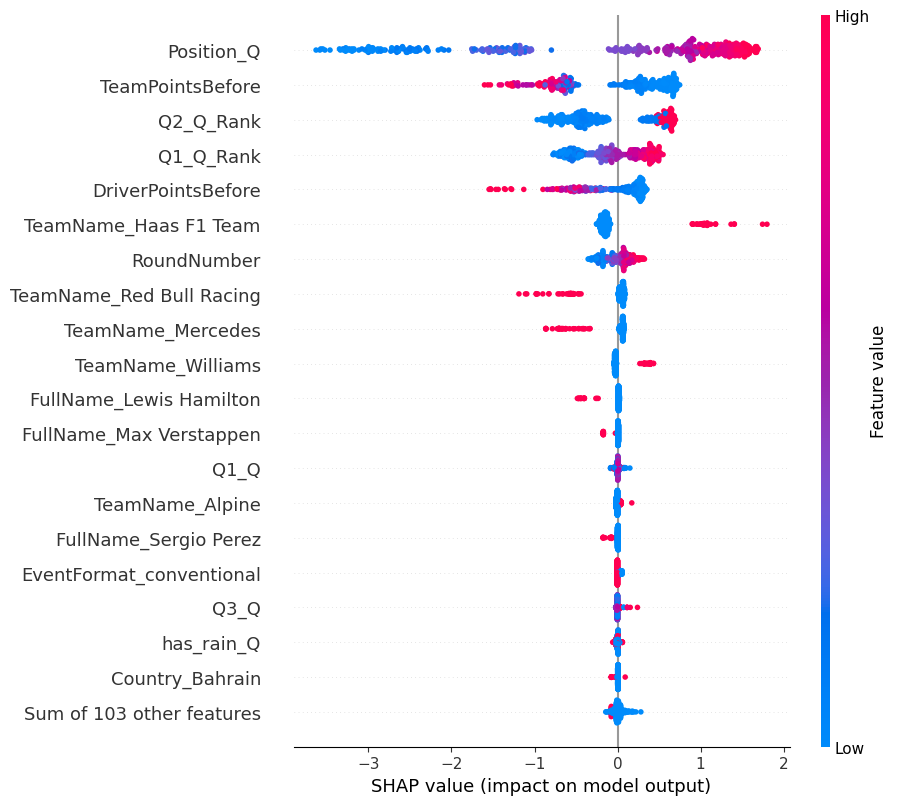

In [27]:
## encoded features
shap.plots.beeswarm(shap_values_xgb, max_display=20)

In [28]:
## credit: Reverse One Hot Encoding by peterdhansen; https://gist.github.com/peterdhansen/ca87cc1bfbc4c092f0872a3bfe3204b2

def combine_one_hot(shap_values, name, mask, return_original=True):
    """  shap_values: an Explanation object
          name: name of new feature
          mask: bool array same lenght as features

         This function assumes that shap_values[:, mask] make up a one-hot-encoded feature
    """
    mask = np.array(mask)
    mask_col_names = np.array(shap_values.feature_names, dtype='object')[mask]

    sv_name = shap.Explanation(shap_values.values[:, mask],
                               feature_names=list(mask_col_names),
                               data=shap_values.data[:, mask],
                               base_values=shap_values.base_values,
                               display_data=shap_values.display_data,
                               instance_names=shap_values.instance_names,
                               output_names=shap_values.output_names,
                               output_indexes=shap_values.output_indexes,
                               lower_bounds=shap_values.lower_bounds,
                               upper_bounds=shap_values.upper_bounds,
                               main_effects=shap_values.main_effects,
                               hierarchical_values=shap_values.hierarchical_values,
                               clustering=shap_values.clustering,
                               )

    new_data = (sv_name.data * np.arange(sum(mask))).sum(axis=1).astype(int)

    svdata = np.concatenate([
        shap_values.data[:, ~mask],
        new_data.reshape(-1, 1)
    ], axis=1)

    if shap_values.display_data is None:
        svdd = shap_values.data[:, ~mask]
    else:
        svdd = shap_values.display_data[:, ~mask]

    svdisplay_data = np.concatenate([
        svdd,
        mask_col_names[new_data].reshape(-1, 1)
    ], axis=1)

    new_values = sv_name.values.sum(axis=1)
    svvalues = np.concatenate([
        shap_values.values[:, ~mask],
        new_values.reshape(-1, 1)
    ], axis=1)
    svfeature_names = list(np.array(shap_values.feature_names)[~mask]) + [name]

    sv = shap.Explanation(svvalues,
                          base_values=shap_values.base_values,
                          data=svdata,
                          display_data=svdisplay_data,
                          instance_names=shap_values.instance_names,
                          feature_names=svfeature_names,
                          output_names=shap_values.output_names,
                          output_indexes=shap_values.output_indexes,
                          lower_bounds=shap_values.lower_bounds,
                          upper_bounds=shap_values.upper_bounds,
                          main_effects=shap_values.main_effects,
                          hierarchical_values=shap_values.hierarchical_values,
                          clustering=shap_values.clustering,
                          )
    if return_original:
        return sv, sv_name
    else:
        return sv

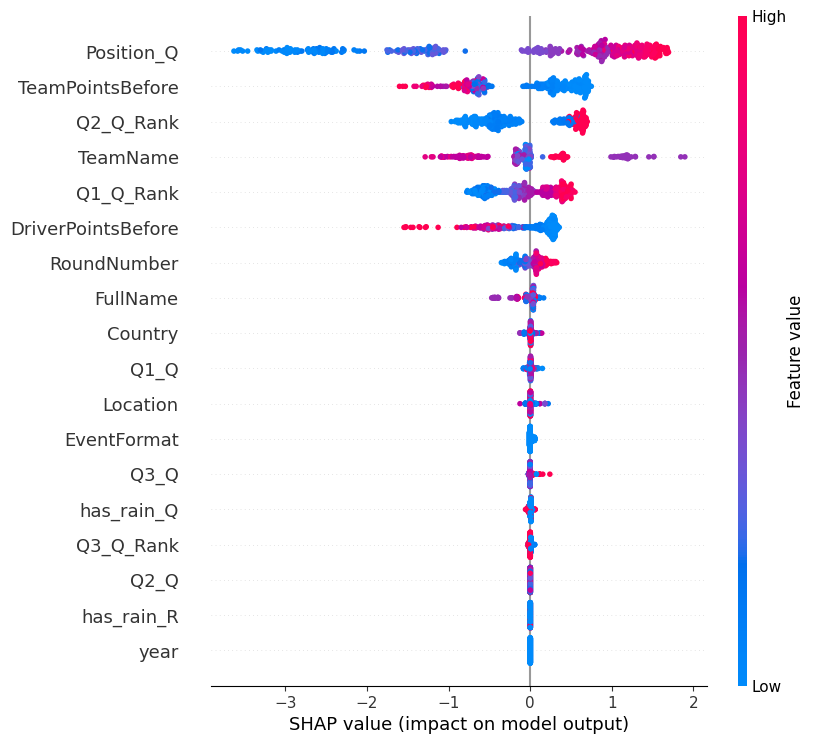

In [29]:
## combine encoded features to original features
for c in categorical_features:
  shap_values_xgb,_ = combine_one_hot(shap_values_xgb, c, [c in n for n in shap_values_xgb.feature_names])

shap.plots.beeswarm(shap_values_xgb, max_display=20)


In [30]:
## Why has_rain_R has no impact on Position_R

In [35]:
## compare position_R when has_rain_R is True or False
mean_position_by_driver_and_rain = train.groupby(['FullName', 'has_rain_R'])['Position_R'].agg(['mean', 'count']).reset_index()\
                                        .pivot(index='FullName', columns='has_rain_R', values=['mean', 'count'])
mean_position_by_driver_and_rain['mean_diff'] = mean_position_by_driver_and_rain[('mean', 1)] - mean_position_by_driver_and_rain[('mean', 0)]
mean_position_by_driver_and_rain.sort_values(by = 'mean_diff')

mean            count       mean_diff
has_rain_R                0.0        1.0   0.0   1.0          
FullName                                                      
Fernando Alonso      9.918367   6.882353  49.0  17.0 -3.036014
Robert Kubica       17.111111  14.666667  18.0   3.0 -2.444444
Romain Grosjean     15.620690  13.333333  29.0   6.0 -2.287356
Carlos Sainz         8.696203   6.416667  79.0  24.0 -2.279536
Max Verstappen       4.443038   2.652174  79.0  23.0 -1.790864
Daniil Kvyat        11.806452  10.142857  31.0   7.0 -1.663594
Lance Stroll        11.868421  10.695652  76.0  23.0 -1.172769
Nikita Mazepin      18.000000  17.166667  15.0   6.0 -0.833333
Kevin Magnussen     14.952381  14.277778  63.0  18.0 -0.674603
Nicholas Latifi     16.022222  15.375000  45.0  16.0 -0.647222
Sergio Perez         7.519481   7.000000  77.0  24.0 -0.519481
Lewis Hamilton       4.215190   3.791667  79.0  24.0 -0.423523
Nyck De Vries       14.875000  14.500000   8.0   2.0 -0.375000
Daniel Ricciardo    10.477612  10.428571  67.0  21.0 -0.049041
Mick Schumacher     15.566667  15.636364  30.0  11.0  0.069697
Logan Sargeant      15.714286  15.800000  14.0   5.0  0.085714
Lando Norris         8.637500   8.791667  80.0  24.0  0.154167
Yuki Tsunoda        13.531915  13.812500  47.0  16.0  0.280585
George Russell      11.287500  11.791667  80.0  24.0  0.504167
Esteban Ocon        10.322581  10.900000  62.0  20.0  0.577419
Pierre Gasly        10.240506  10.875000  79.0  24.0  0.634494
Sebastian Vettel    10.229508  11.055556  61.0  18.0  0.826047
Kimi Räikkönen      12.431818  13.307692  44.0  13.0  0.875874
Liam Lawson         12.000000  13.000000   4.0   1.0  1.000000
Nico Hulkenberg     12.974359  14.000000  39.0   9.0  1.025641
Antonio Giovinazzi  13.533333  14.846154  45.0  13.0  1.312821
Alexander Albon     10.852459  12.166667  61.0  18.0  1.314208
Charles Leclerc      6.800000   8.875000  80.0  24.0  2.075000
Guanyu Zhou         13.545455  16.090909  33.0  11.0  2.545455
Valtteri Bottas      7.900000  11.583333  80.0  24.0  3.683333
Oscar Piastri       10.058824  13.800000  17.0   5.0  3.741176
Jack Aitken         16.000000        NaN   1.0   NaN       NaN
Pietro Fittipaldi   18.000000        NaN   2.0   NaN       NaN

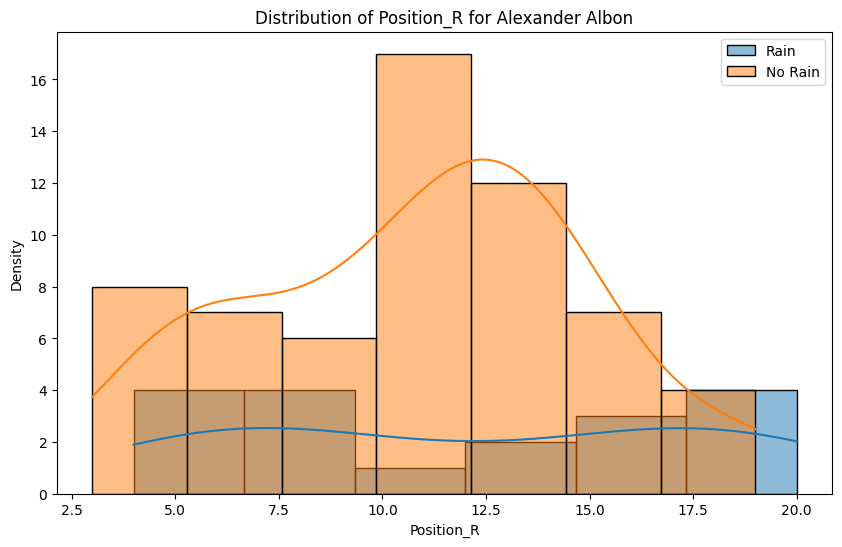

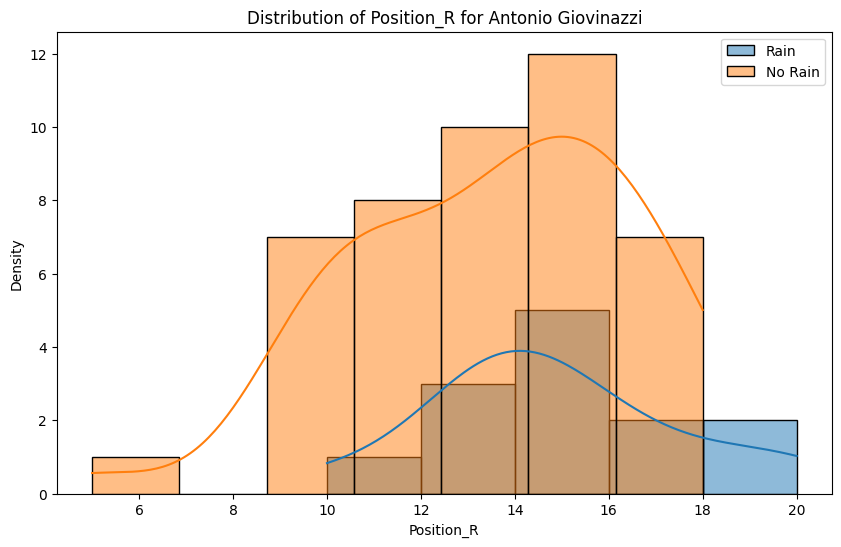

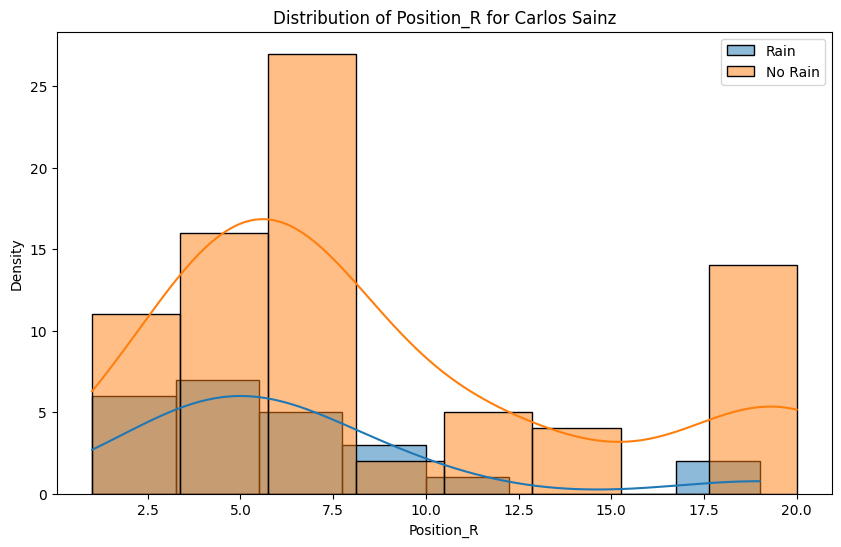

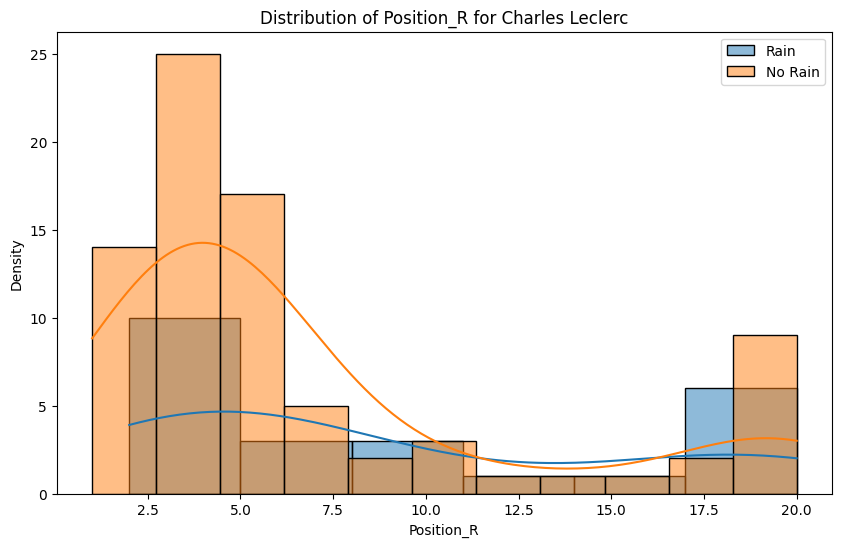

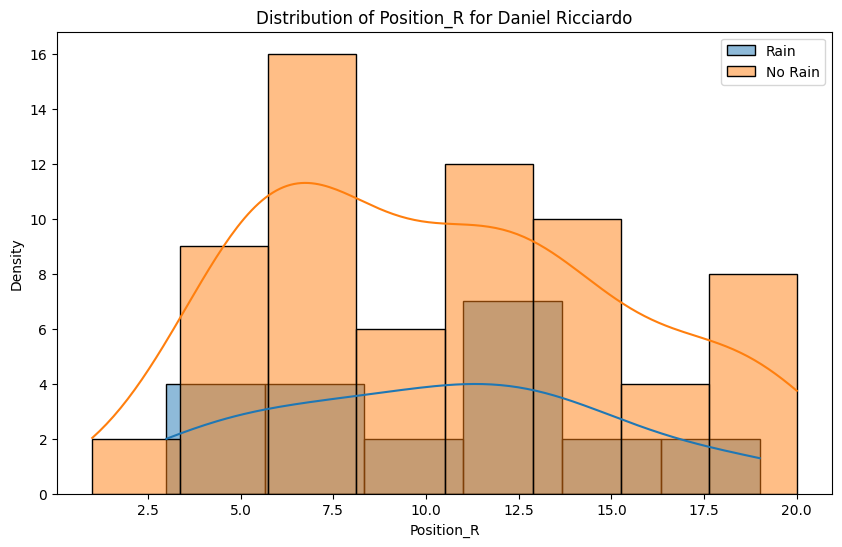

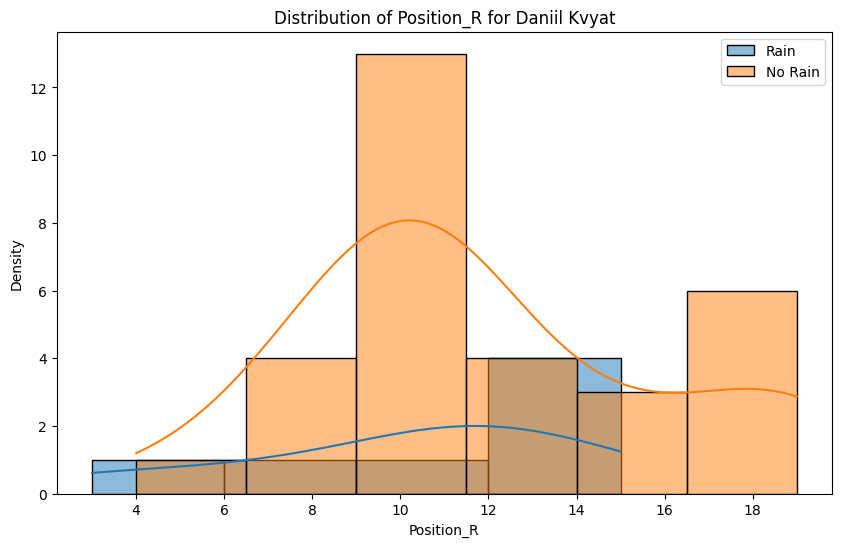

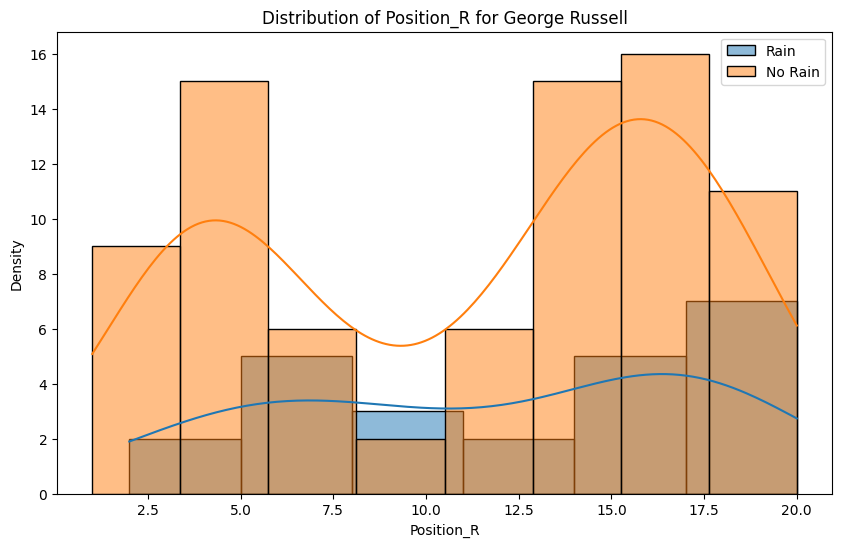

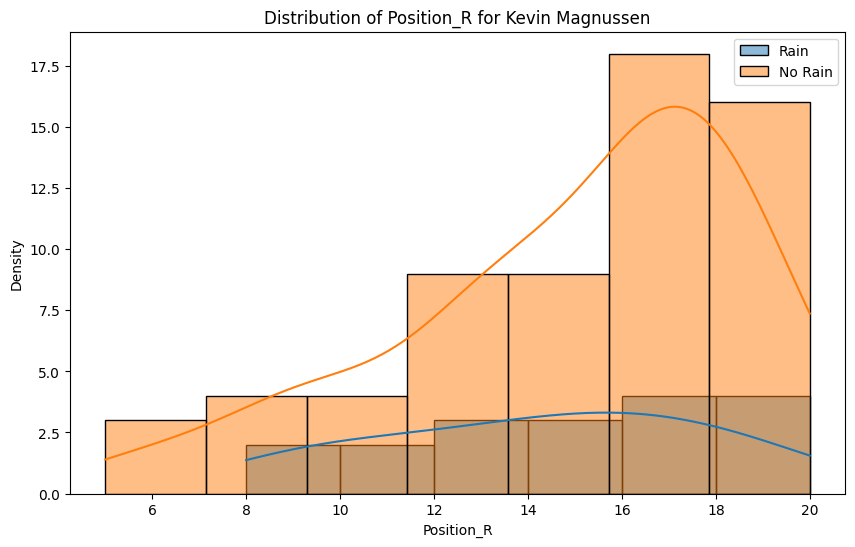

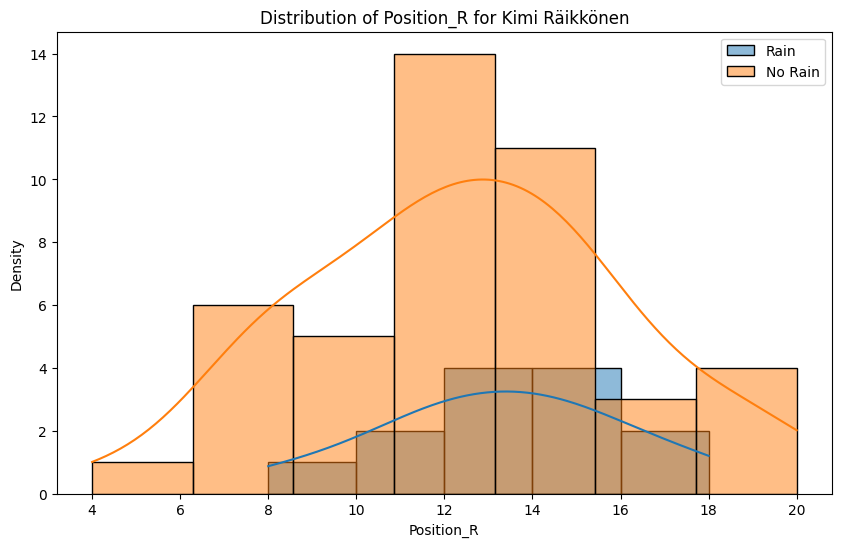

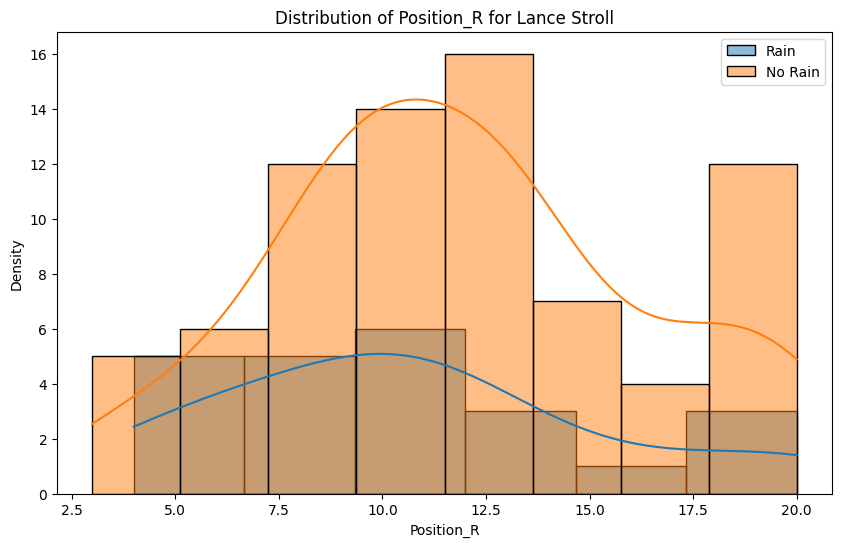

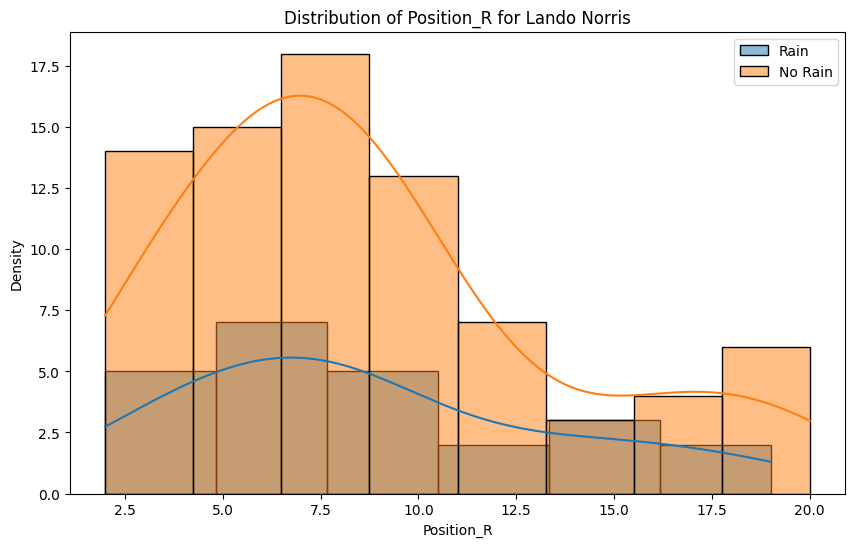

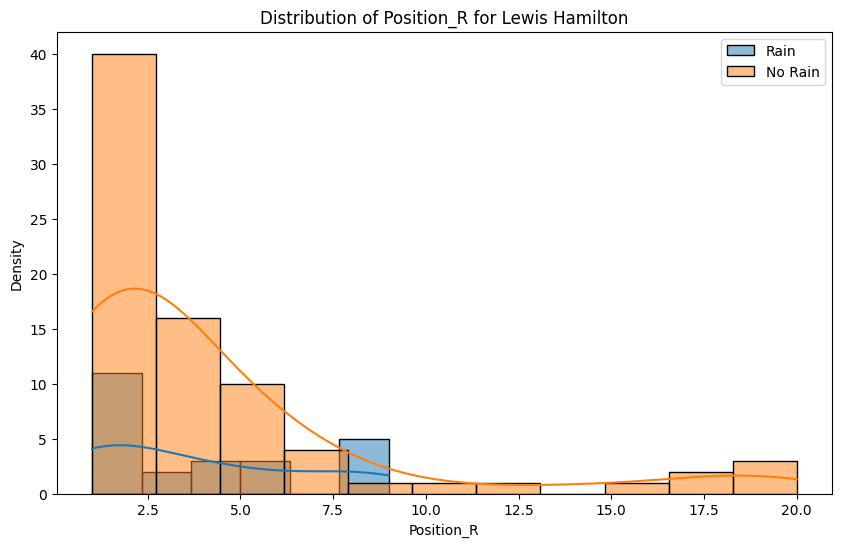

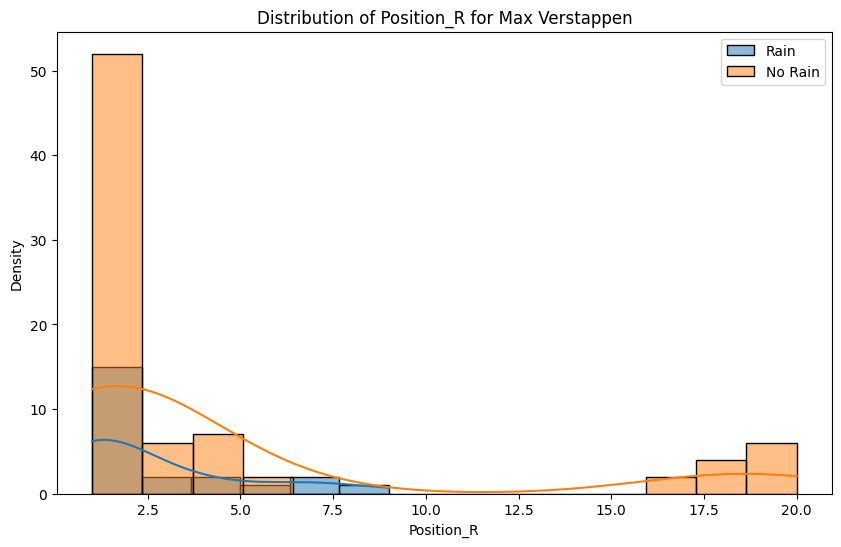

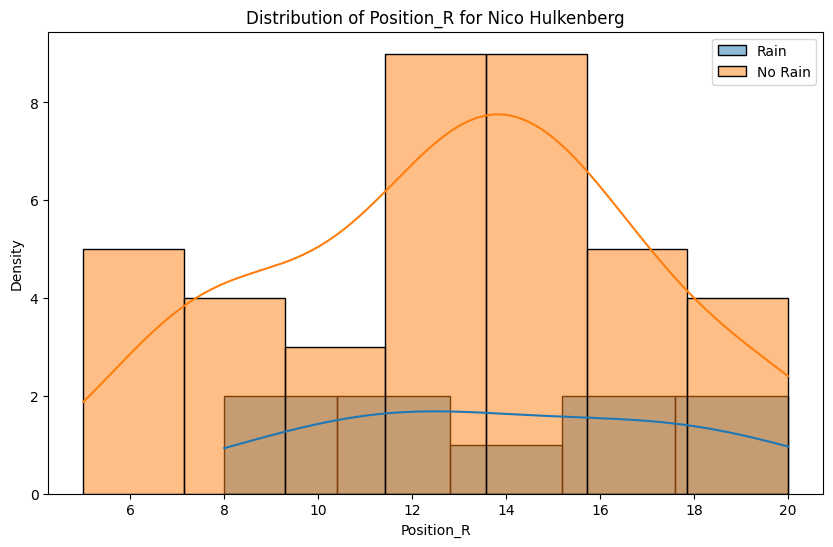

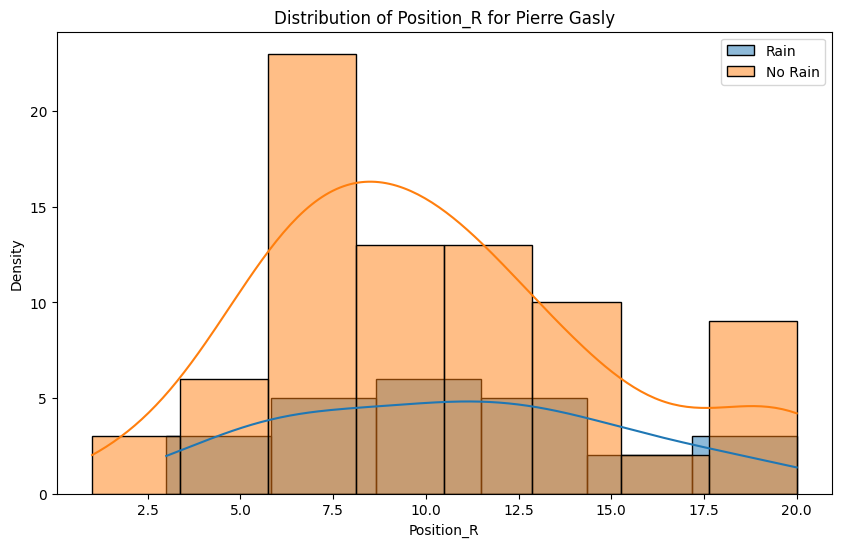

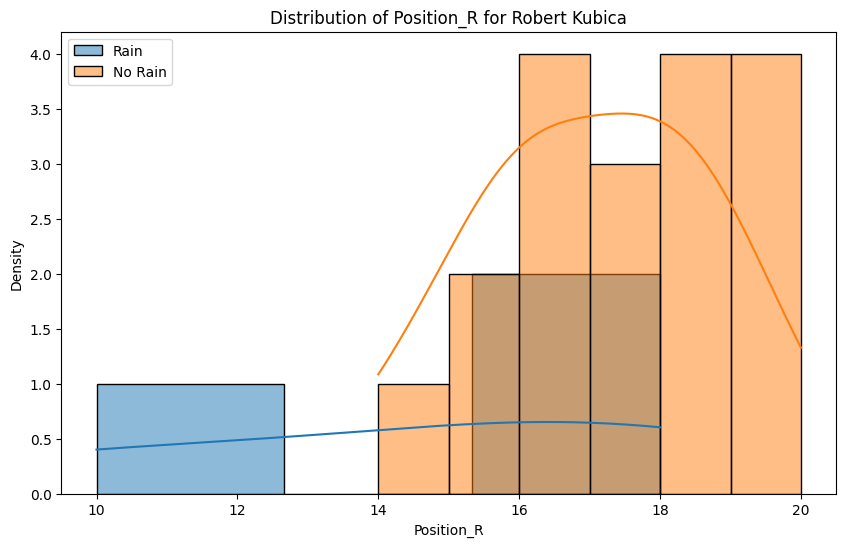

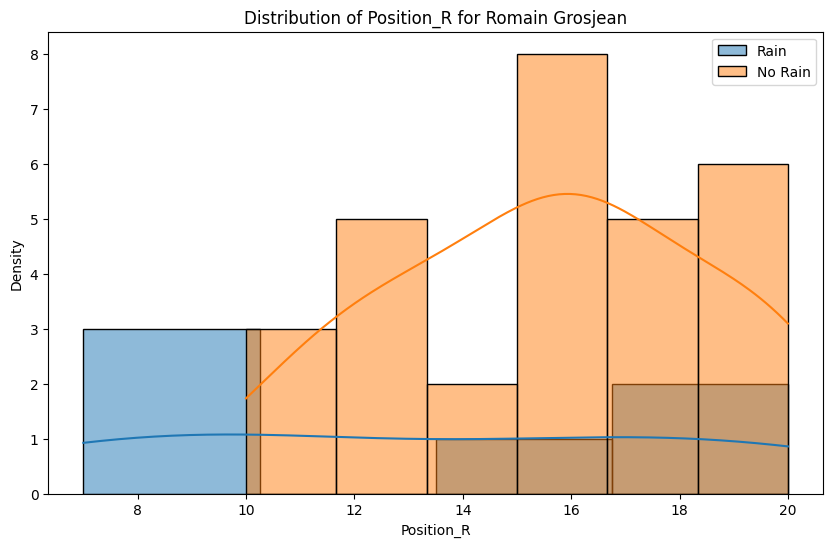

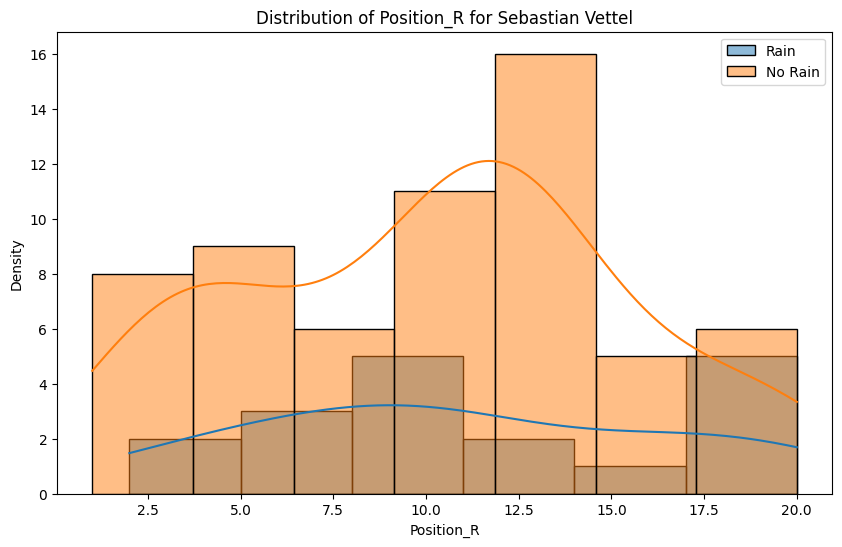

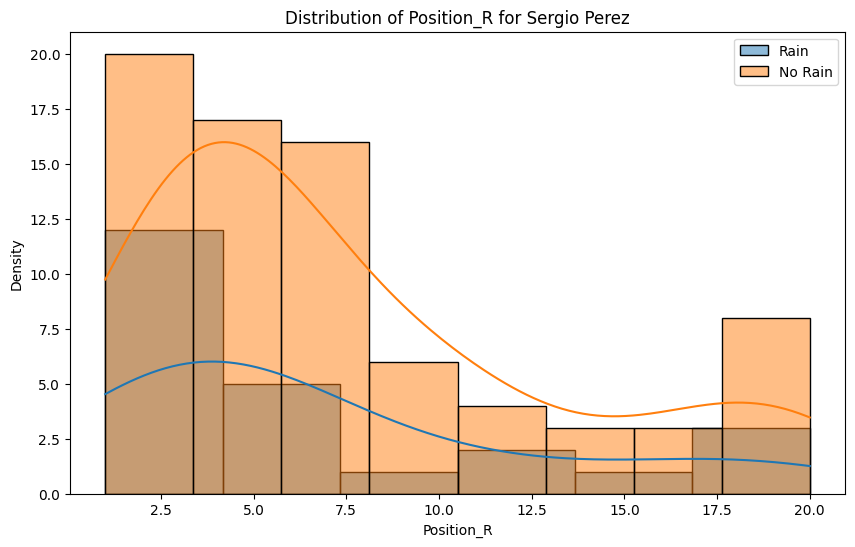

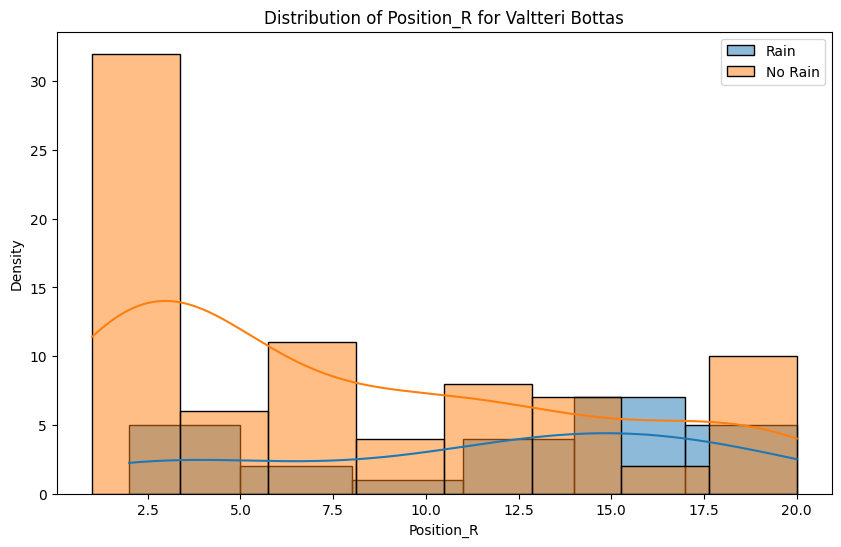

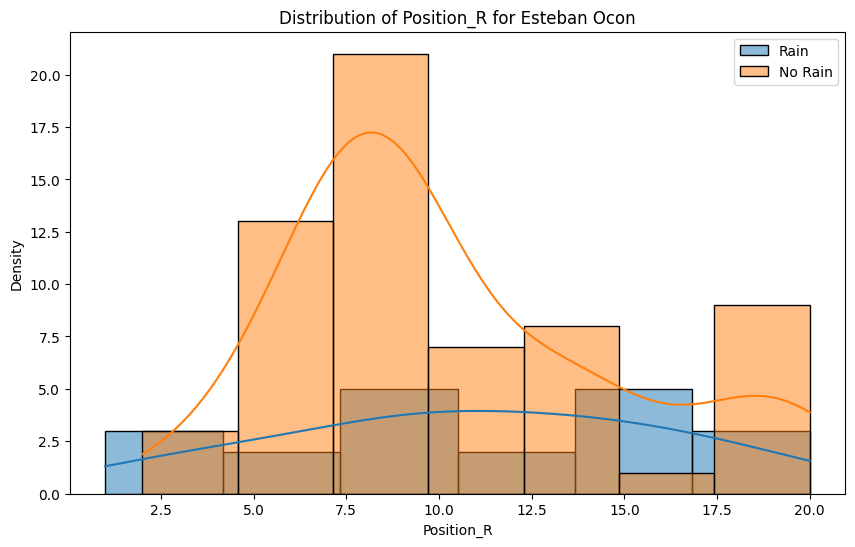

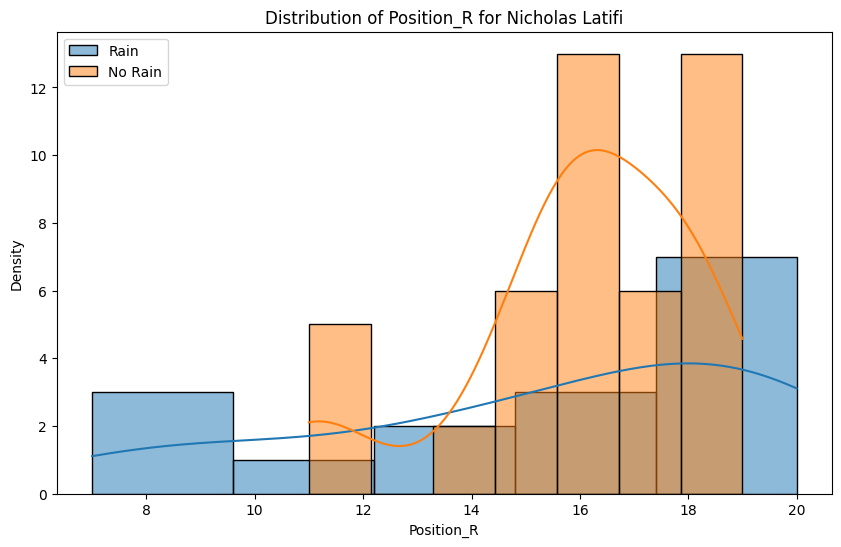

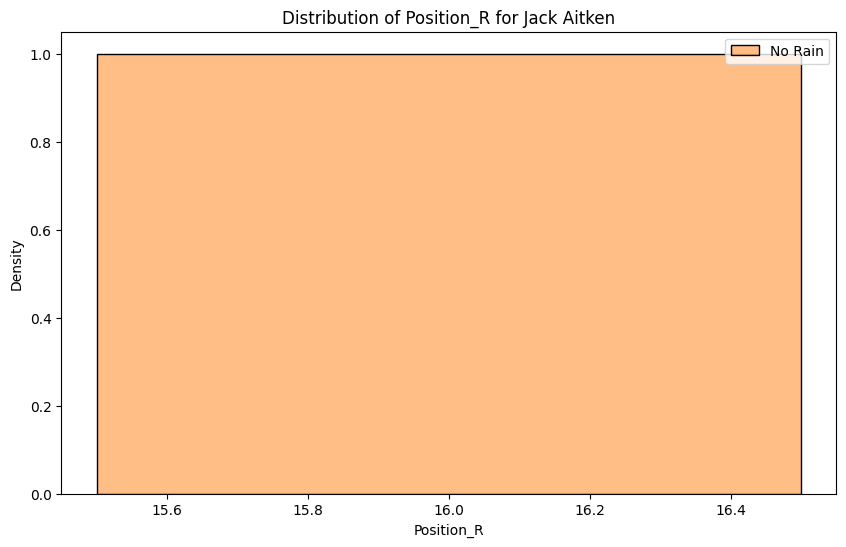

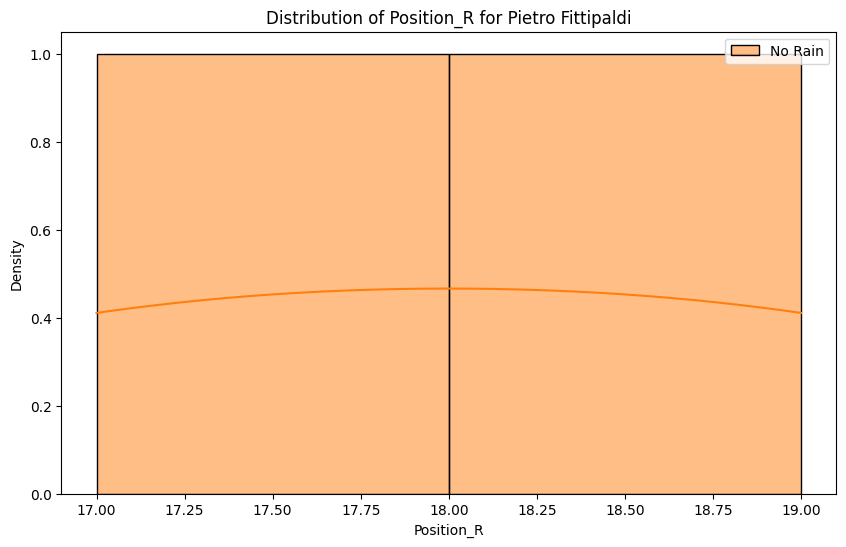

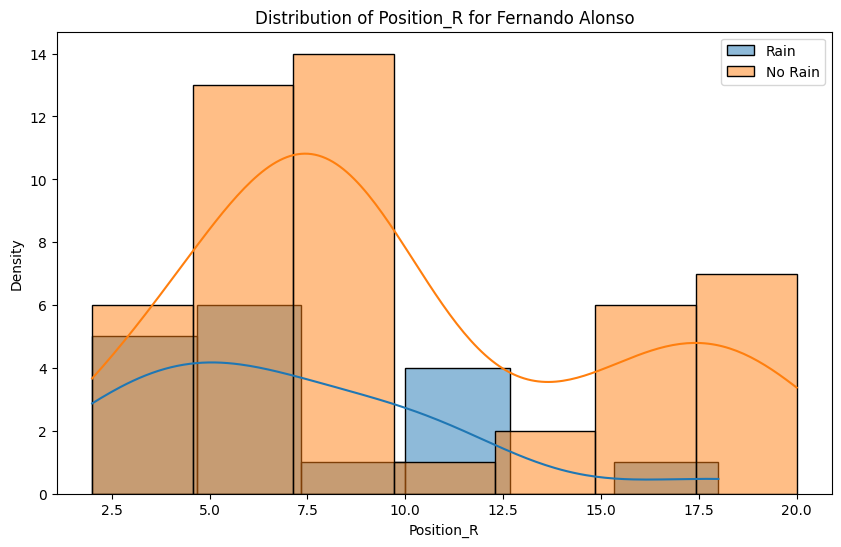

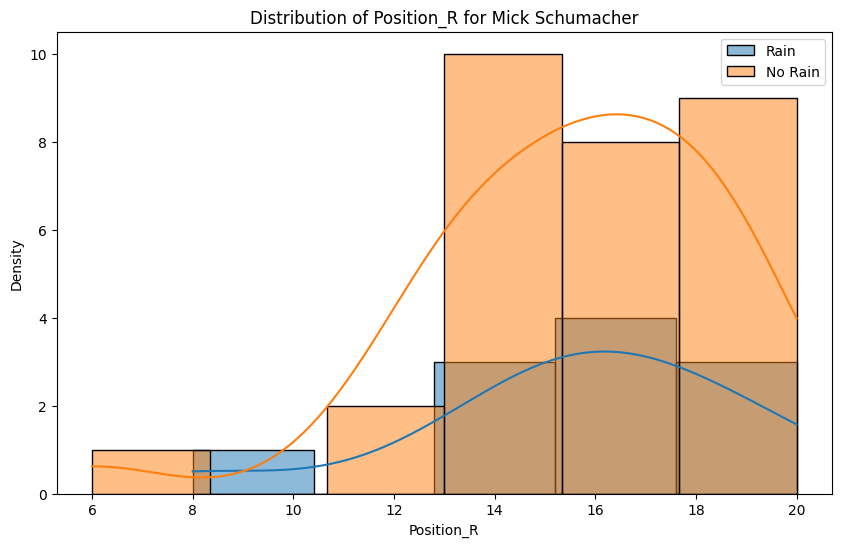

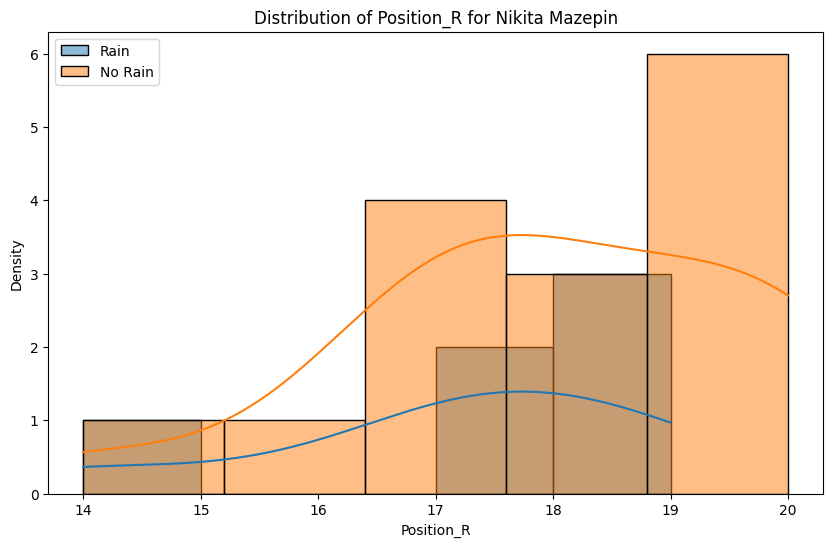

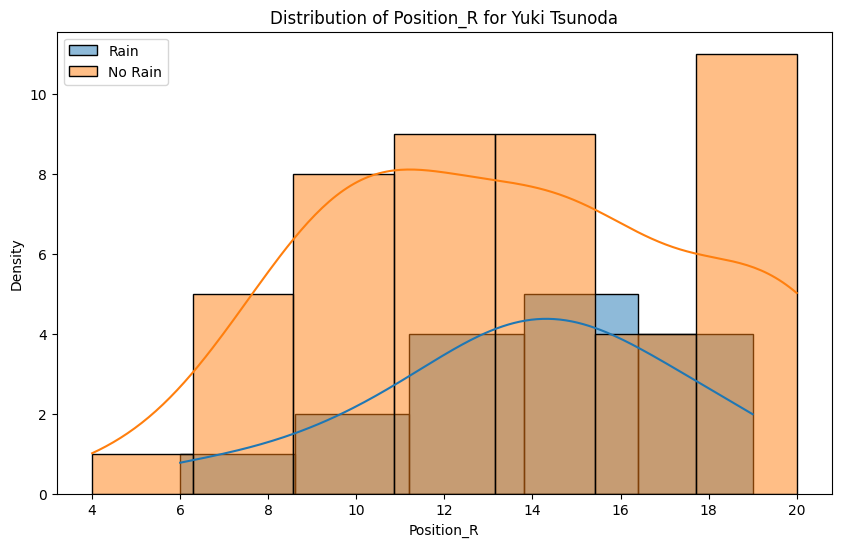

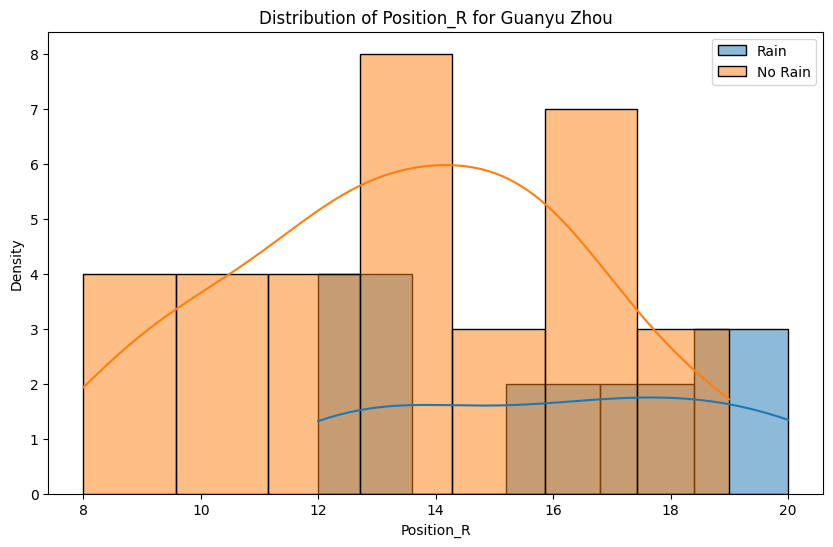

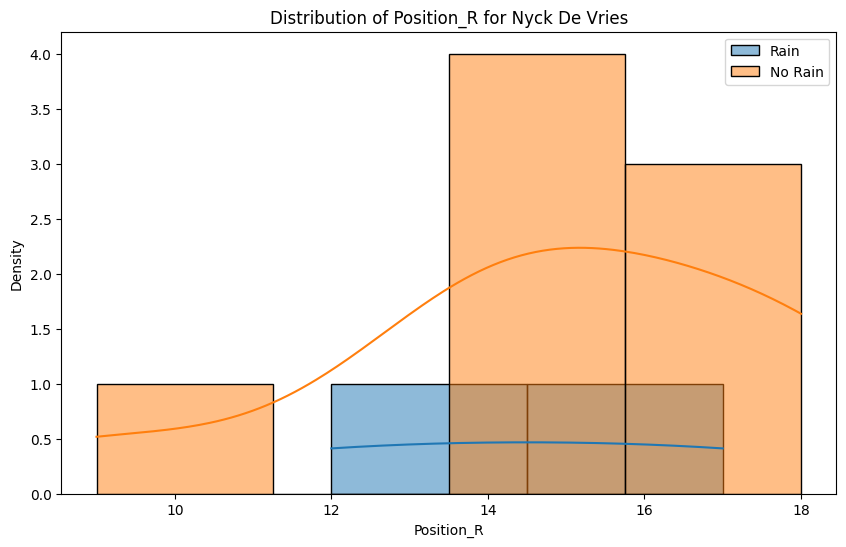

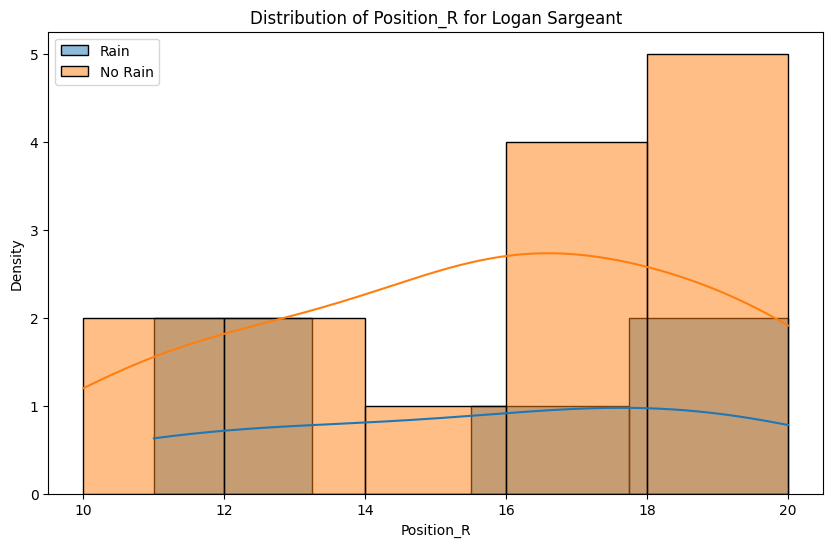

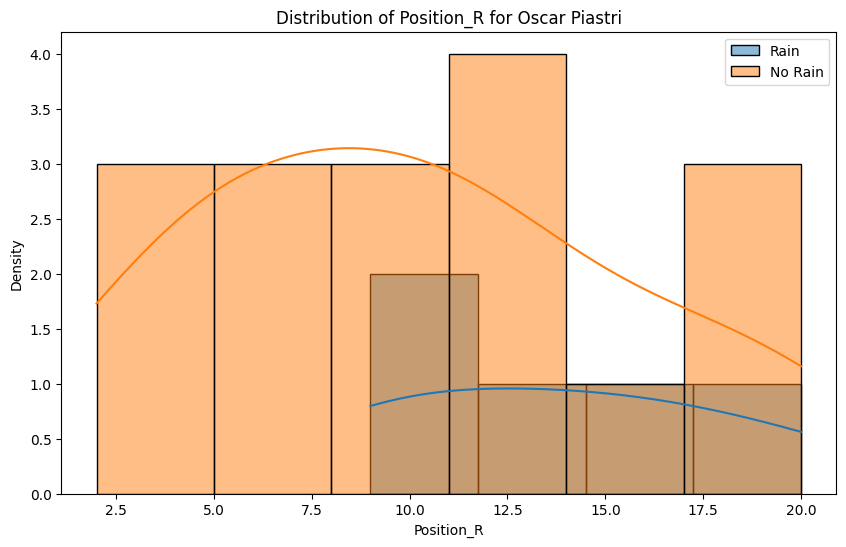

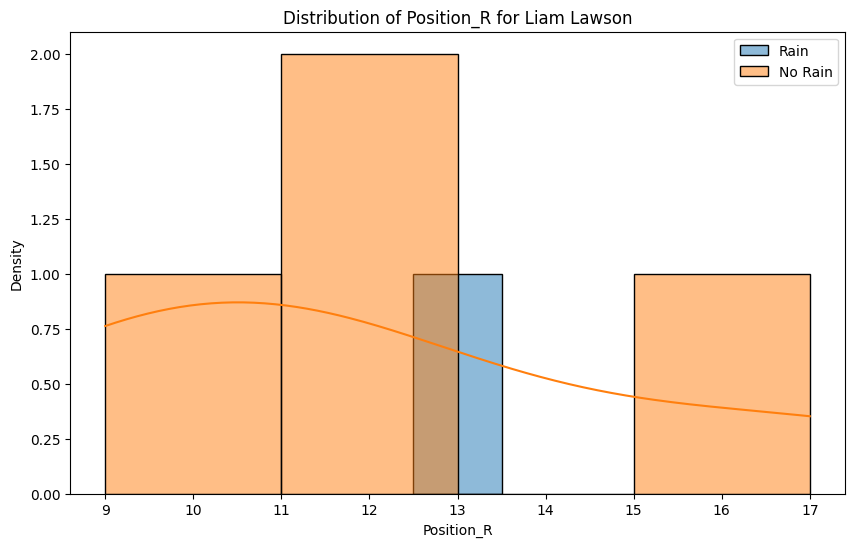

In [36]:
## compare position_R distribution when has_rain is True or False
def plot_position_distribution(df, driver):
  plt.figure(figsize=(10, 6))
  sns.histplot(df[(df['FullName'] == driver) & (df['has_rain_R'] == 1)]['Position_R'], label='Rain', fill=True, kde = True)
  sns.histplot(df[(df['FullName'] == driver) & (df['has_rain_R'] == 0)]['Position_R'], label='No Rain', fill=True, kde = True)
  plt.title(f'Distribution of Position_R for {driver}')
  plt.xlabel('Position_R')
  plt.ylabel('Density')
  plt.legend()
  plt.show()

for driver in train['FullName'].unique():
  plot_position_distribution(train, driver)